In [ ]:
# import libraries
import sys
import os
import re
import pickle
import nltk
import time
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])
import pandas as pd
import io
import numpy as np
from sqlalchemy import create_engine
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.multioutput import MultiOutputClassifier
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
#from google.colab import files

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
df = pd.read_csv("mental health.csv")
df.head()


,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [ ]:
# removing the first column
# as it just the index and not required

df = df.drop(columns=["Unnamed: 0"])
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [ ]:
value_counts = df['status'].value_counts()

# Create a bar chart
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Unique Values')
plt.ylabel('Number of Rows')
plt.title('Number of Rows for Each Unique Value in "status"')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [ ]:
# total no. of rows and columns in the dataset
print("The total no. of rows & columns in the dataset are: ",   df.shape)

# enter to insert an empty line between two print statements
print("\n")

# count of non-null rows in each column
# to identify if there are null rows in the column
print("The total no. of non-null rows in each column are:\n",  df.count())

The total no. of rows & columns in the dataset are:  (53044, 2)


The total no. of non-null rows in each column are:
 statement    52681
status       53042
dtype: int64


The above results tell us that there are 53,044 rows and 2 columns in the dataset. The count of non-null rows for the column **statement** is 52,681 which means there are 363 null rows in the column; the count of non-null rows in the column **status** is 53,042 which means there are 2 null rows in the column. We will remove these null rows now.

In [ ]:
df = df.dropna(how="any", axis=0) # drop null rows
print("The total no. of non-null rows in each column are:\n",  df.count())

# we see below that counts in both columns are now equal

The total no. of non-null rows in each column are:
 statement    52680
status       52680
dtype: int64


In [ ]:
df1 = df

df1 = pd.get_dummies(data=df1, columns=["status"], dtype=int)
df1.head()

,statement,status_Anxiety,status_Bipolar,status_Depression,status_Normal,status_Personality disorder,status_Stress,status_Suicidal
0,oh my gosh,1,0,0,0,0,0,0
1,"trouble sleeping, confused mind, restless hear...",1,0,0,0,0,0,0
2,"All wrong, back off dear, forward doubt. Stay ...",1,0,0,0,0,0,0
3,I've shifted my focus to something else but I'...,1,0,0,0,0,0,0
4,"I'm restless and restless, it's been a month n...",1,0,0,0,0,0,0


In [ ]:
X = df1["statement"]
y = df1.drop(columns=["statement"])
category_names = y.columns

# return X, y, category_names

In [ ]:
def tokenize(text):
    """
    input - text

    output - cleaned text after removing extra whitespaces, URLs, and lowering all characters

    """

    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")

    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

In [ ]:
# creating a pipeline to perform
# classification
pipeline1 = Pipeline([
    ('features', FeatureUnion([

        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer())
        ]))
    ])),

    ('clf', RandomForestClassifier())
])

pipeline2 = Pipeline([
    ('features', FeatureUnion([

        ('text_pipeline', Pipeline([
            ('count_vectorizer', CountVectorizer(tokenizer=tokenize)),
            ('tfidf_transformer', TfidfTransformer())
        ])),
    ])),

    ('clf', MultiOutputClassifier(AdaBoostClassifier()))
])

In [ ]:

start_time = time.time() # start of model training 

# train RandomForestclassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
model1 = pipeline1.fit(X_train, y_train)
end_time = time.time() # end of model training

runtime1 = end_time - start_time # calculation of runtime
print("Training time: ", runtime1)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Training time:  331.8656129837036


In [ ]:
start_time = time.time() # start of model training

# train AdaBoostclassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
model2 = pipeline2.fit(X_train, y_train)
end_time = time.time() # end of model training

runtime2 = end_time - start_time # calculation of runtime
print("Training time: ", runtime2)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Training time:  322.59967041015625


In [ ]:
 # testing the RandomForestClassifier model
y_pred1 = model1.predict(X_test)

# extract a classification report to evaluate performance
print(classification_report(y_test.values, y_pred1, target_names=category_names))

                             precision    recall  f1-score   support

             status_Anxiety       0.96      0.13      0.22       942
             status_Bipolar       1.00      0.14      0.24       684
          status_Depression       0.79      0.43      0.56      3856
              status_Normal       0.92      0.90      0.91      4138
status_Personality disorder       1.00      0.27      0.42       261
              status_Stress       1.00      0.18      0.31       670
            status_Suicidal       0.77      0.12      0.20      2619

                  micro avg       0.87      0.46      0.61     13170
                  macro avg       0.92      0.31      0.41     13170
               weighted avg       0.86      0.46      0.54     13170
                samples avg       0.46      0.46      0.46     13170



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
 # testing the AdaBoostClassifier model
y_pred2 = model2.predict(X_test)

# extract a classification report to evaluate performance
print(classification_report(y_test.values, y_pred2, target_names=category_names))

                             precision    recall  f1-score   support

             status_Anxiety       0.79      0.62      0.70       942
             status_Bipolar       0.86      0.65      0.74       684
          status_Depression       0.73      0.60      0.66      3856
              status_Normal       0.87      0.92      0.89      4138
status_Personality disorder       0.80      0.50      0.61       261
              status_Stress       0.64      0.37      0.47       670
            status_Suicidal       0.69      0.53      0.60      2619

                  micro avg       0.79      0.68      0.73     13170
                  macro avg       0.77      0.60      0.67     13170
               weighted avg       0.78      0.68      0.72     13170
                samples avg       0.65      0.68      0.66     13170



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# metrics for RandomForestClassfier
accuracy1 = accuracy_score(y_test, y_pred1)
precision1 = precision_score(y_test, y_pred1, average='weighted')
recall1 = recall_score(y_test, y_pred1, average='weighted')
f1_1 = f1_score(y_test, y_pred1, average='weighted')


# metrics for AdaBoostClassifier
accuracy2 = accuracy_score(y_test, y_pred2)
precision2 = precision_score(y_test, y_pred2, average='weighted')
recall2 = recall_score(y_test, y_pred2, average='weighted')
f1_2 = f1_score(y_test, y_pred2, average='weighted')

In [ ]:
# combining metrics for both models
# in a variable
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
model1_scores = [accuracy1, precision1, recall1, f1_1]
model2_scores = [accuracy2, precision2, recall2, f1_2]

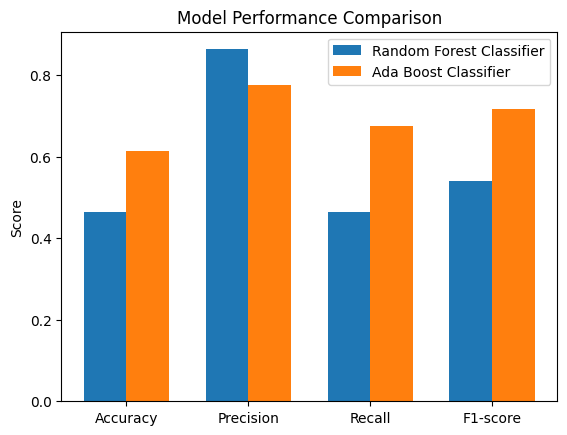

In [ ]:
# plot the metrics for both models
# on a bar chart

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, model1_scores, width, label='Random Forest Classifier')
rects2 = ax.bar(x + width/2, model2_scores, width, label='Ada Boost Classifier')

# Add labels, title, and legend
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Display the plot
plt.show()

The cells below are not required for this analysis. These cells will save both models to a pickle file, these files can be used if a model is prepared to be hosted on a webapp. 

In [ ]:
# save RandomForestClassifier to a pickle file

filename = "random_forest_model.pkl"

with open(filename, 'wb') as file:
    pickle.dump(model1, file)

In [ ]:
# save AdaBoost to a pickle file

filename = "ada_boost_model.pkl"

with open(filename, 'wb') as file:
    pickle.dump(model2, file)